In [5]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown (see cell below)
# or pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# id = "1-44s78x-_XgSryME7_uJU3Kv-Poe202a" LUCAS NIRS
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

# paperspace only
!pip install spanda

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm


from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, 
                                    AnalytesTfm, SNVTfm, RandWAvgTfm, NormalizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [3]:
# Only samples with spectra
#path = Path('../../_data/lucas-nirs')
path = Path('/root/lucas-nirs')
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|██████████| 21859/21859 [00:00<00:00, 50322.90it/s]

n samples: 21782


In [4]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [5]:
# Only strictly positive measurements (
paths = [p for p in paths if AnalytesTfm(analytes=['OC'])(get_target(p)) != 0] 
print(f'n samples: {len(paths)}')

n samples: 21782


In [ ]:
# Stats

## Spectra
#Xs = []
#n = 0
#for p in paths:
#    Xs.append(SpectraTfm()(get_target(p)))
#    n += 1 
#    if n > 1000: break
#print(f'X mean: {torch.mean(torch.concat(Xs))}, X Std: {torch.std(torch.concat(Xs))}');

In [ ]:
ys = []
n = 0
for p in paths:
    ys.append(AnalytesTfm(analytes=['K'])(get_target(p)))
    n += 1 
    if n > 1000: break

In [ ]:
torch.concat(ys).min()

Analytes(1.3000)

In [ ]:
torch.concat(ys).max()

Analytes(10030.9004)

In [ ]:
torch.concat(ys).mean()

Analytes(211.0901)

(array([  1.,   1.,   2.,   0.,   1.,  15.,  39.,  66., 107., 163., 206.,
        180., 124.,  67.,  22.,   3.,   3.,   0.,   0.,   1.]),
 array([0.11394334, 0.30831316, 0.50268298, 0.69705284, 0.89142263,
        1.08579254, 1.28016233, 1.47453213, 1.66890192, 1.86327183,
        2.05764151, 2.25201154, 2.44638133, 2.64075112, 2.83512092,
        3.02949071, 3.2238605 , 3.41823053, 3.61260033, 3.80697012,
        4.00133991]),
 <BarContainer object of 20 artists>)

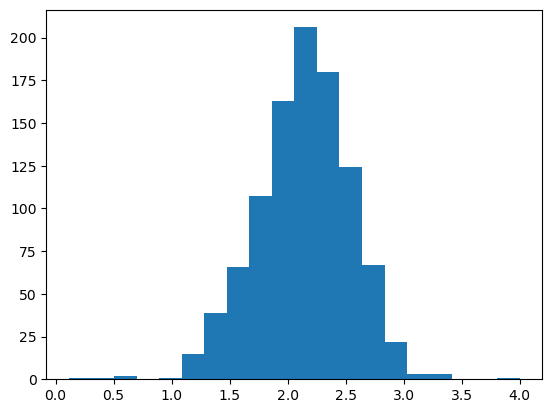

In [ ]:
import matplotlib.pyplot as plt

plt.hist(torch.log10(torch.concat(ys)), bins=20)
#plt.xscale('log') 

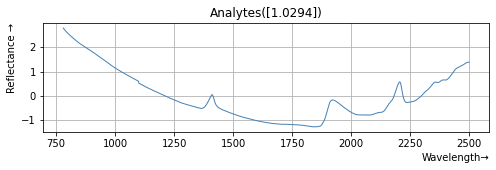

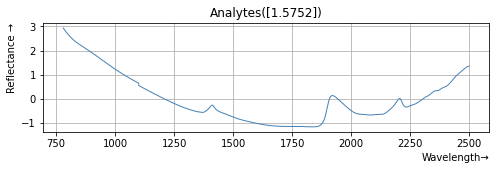

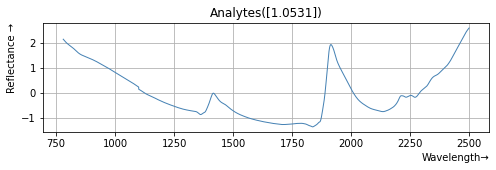

In [6]:
n_smp = None # None for all

#get_spectra = lambda o: L(fname for fname in o.ls() if re.match('\d+_\d', fname.name))
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=['OC'])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), SNVTfm(),
                              LogTfm()])

dls = dblock.dataloaders(paths[:n_smp], bs=3)
dls.show_batch()

In [14]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score()).to_fp16()

SuggestedLRs(valley=0.0004786300996784121)

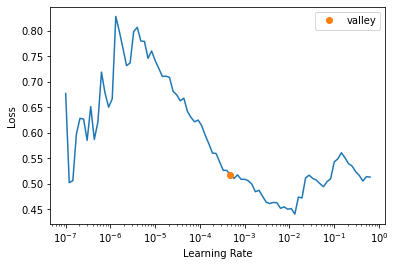

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.085867,0.113523,0.332285,02:25
1,0.076191,0.080692,0.525387,02:23
2,0.124123,0.086409,0.491763,02:24
3,0.070655,0.079258,0.533826,02:24
4,0.070963,0.064264,0.622015,02:24
5,0.082023,0.063892,0.624205,02:23
6,0.059538,0.065327,0.615763,02:23
7,0.067921,0.047351,0.721493,02:25
8,0.048481,0.069140,0.593333,02:24
9,0.061081,0.067230,0.604570,02:26


In [17]:
learn.save('xresnet18-oc-nirs-lucas-40-epochs-lr-1e3-r2-0-86')

Path('models/xresnet18-oc-nirs-lucas-40-epochs-lr-1e3-r2-0-86.pth')